____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e\frac{\partial T_e}{\partial t}   &= - \frac{1}{r}\frac{\partial}{\partial r}\left[ r \left(  v(P_e+E_e) - k_e \frac{\partial T_e}{\partial r}\right) \right]  - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t}  &= - \frac{1}{r}\frac{\partial}{\partial r} \left[ r \left(  v(P_i+E_i) - k_i \frac{\partial T_i}{\partial r}\right) \right] + G (T_e - T_i)
\end{align}
$$
which assumes a cylindrical plasma composed of electrons and ions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
""
from exp_setup import Cylindrical_Grid, Experiment, Measurements
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel

import cProfile

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Experimental Setup

In [2]:
grid  = Cylindrical_Grid(200e-6, N=400) 
Z, A = 54, 131
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"
ionization_file="Xenon_5bar_Saha_solution_data.txt"

model_kwargs = {'gas_name':'Xenon', 'ionization_model':'input', 'ionization_file' : ionization_file, 'model':"SMT", 'ion_temperature_model':'MD','ion_temperature_file':dih_file,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)


### Fit to Initial Experimental Values

(0.0, 4.0)

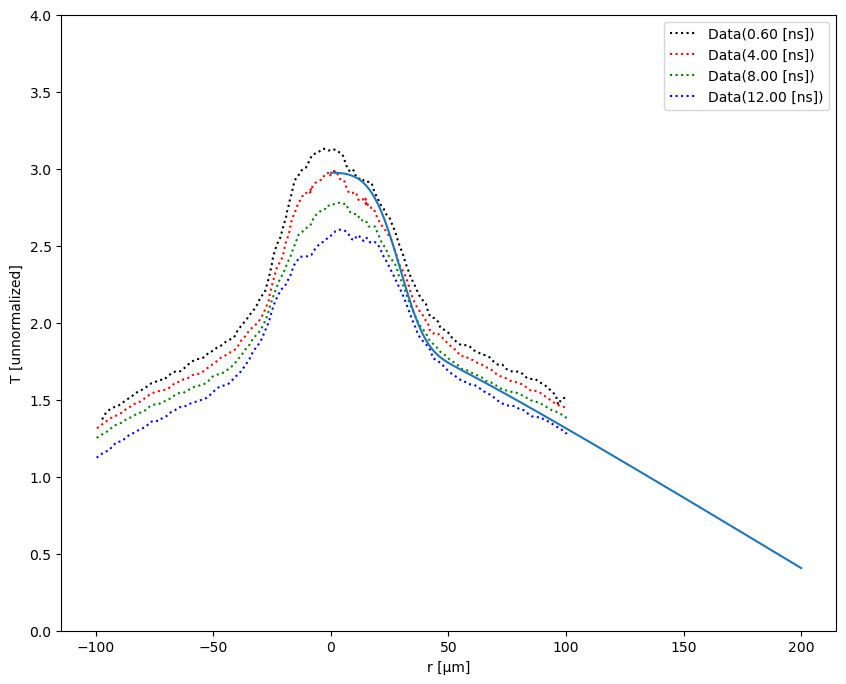

In [3]:
profile_files = ["data/" + f"Xe_5bar_profile_{time}ns.txt" for time in ["0.6","4","8","12"] ]    
profile_datasets = [] +  [read_csv(file, delim_whitespace=True, header=2) for file in profile_files]

g, ax = plt.subplots(figsize=(10,8))
colors = ['k','r','g','b']
linestyles = ['--'] + ['-']*4
times = [0.6,4,8, 12]
for i, (data, times ) in enumerate(zip(profile_datasets, times)):
    # plot_intensity(measurement, ax=ax, color=colors[i], normalization =100/np.max(profile_measurements[0].I_unnormalized_of_r) , label=f"Sim({t*1e9:0.2f} [ns])",linestyle=linestyles[i])
    
    # if i>0:
    ax.plot(data['r[μm]'], data['I[arb]']**0.25, color=colors[i], linestyle=':', label=f"Data({times:0.2f} [ns])")
    ax.legend()

# normalization = 100/np.max(profile_measurements[0].I_unnormalized_of_r)


T_distribution = lambda r, T_max, FWHM: T_max*np.exp(-np.log(2)* ( 4*r**2/FWHM**2)**2 ) #Gaussian Laser

x = np.linspace(0,200e-6,num=500)
Δx= 0#5
T_middle = T_distribution((x*1e6-Δx),0.1, 50)
T_outer = (2.3 - np.sqrt( 0.1 + (0.7/75*(x*1e6-Δx))**2))

power = 0.5
ax.plot(x*1e6,  (T_middle**power +  T_outer**power)**(1/power) )
ax.set_ylabel("T [unnormalized]")
ax.set_xlabel("r [μm]" )
ax.set_ylim(0,4)

In [39]:
# Te_initial, gaussian_FWHM = 1.49878893e+04, 1.06721138e-04
Te_initial, gaussian_FWHM = 2.2e+04, 1.06721138e-04

model_kwargs = {'gas_name':'Xenon', 'ionization_model':'TF', 'ionization_file' : ionization_file, 'model':"SMT", 'ion_temperature_model':'MD','ion_temperature_file':dih_file,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Xenon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

# Custom Temperature distribution
T_distribution = lambda r, T_max, FWHM: T_max*np.exp(-np.log(2)* ( 4*r**2/FWHM**2)**2 ) #Gaussian Laser
T_middle = T_distribution( Xenon.grid.r*1e6 ,0.1, 50)
T_outer_func = lambda r: np.max([0, 2.3 - np.sqrt( 0.1 + (0.7/75*(r*1e6))**2)])
T_outer_func = np.vectorize(T_outer_func)

T_outer = T_outer_func(Xenon.grid.r)

power = 0.5            
Xenon.Te = (T_middle**power +  T_outer**power)**(1/power)
Xenon.Te = Xenon.Te * Te_initial/np.max(Xenon.Te )
Xenon.Te
Xenon.make_physical_timescales()

ttm = HydroModel(Xenon, model = model_kwargs["model"], electron_model='equilibrium')
ttm.Zbar = ttm.experiment.Zbar_func(ttm.n_i, ttm.Te)
ttm.n_e  = ttm.n_i * ttm.Zbar
# Print Setup
initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 150e-6, Nx =200, Nz=100)

### Plotting Initial Experimental Setup

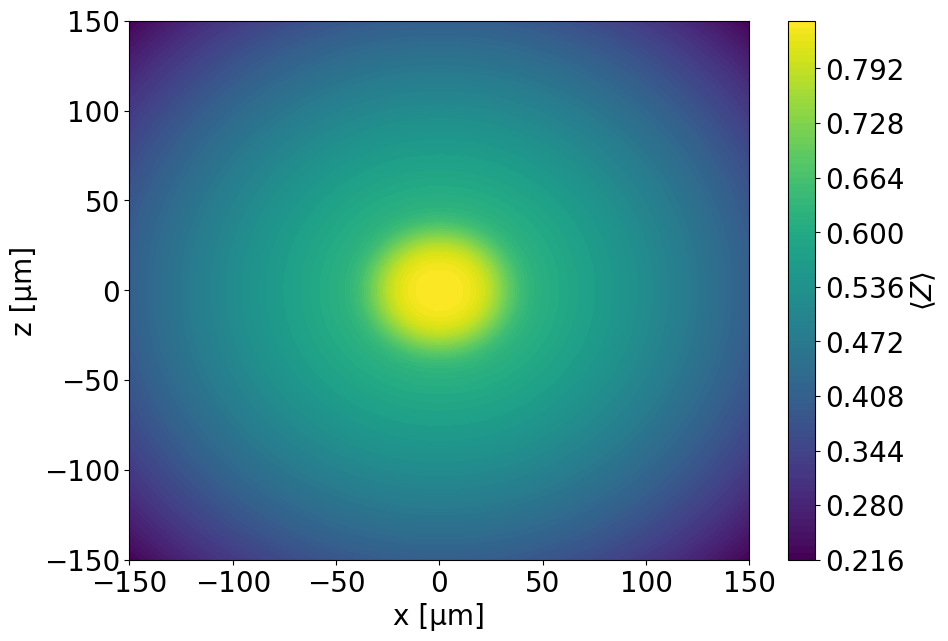

In [40]:
initial_setup.plot_parameter( initial_setup.Zbar_grid, r"$\langle Z \rangle$")

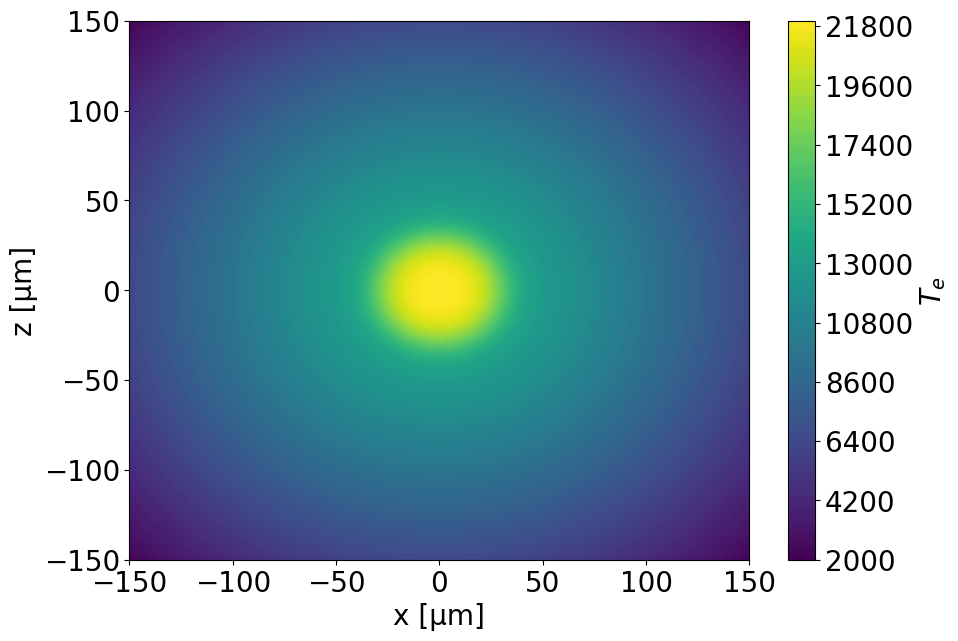

In [41]:
initial_setup.plot_parameter( initial_setup.Te_grid, r"$T_e$")

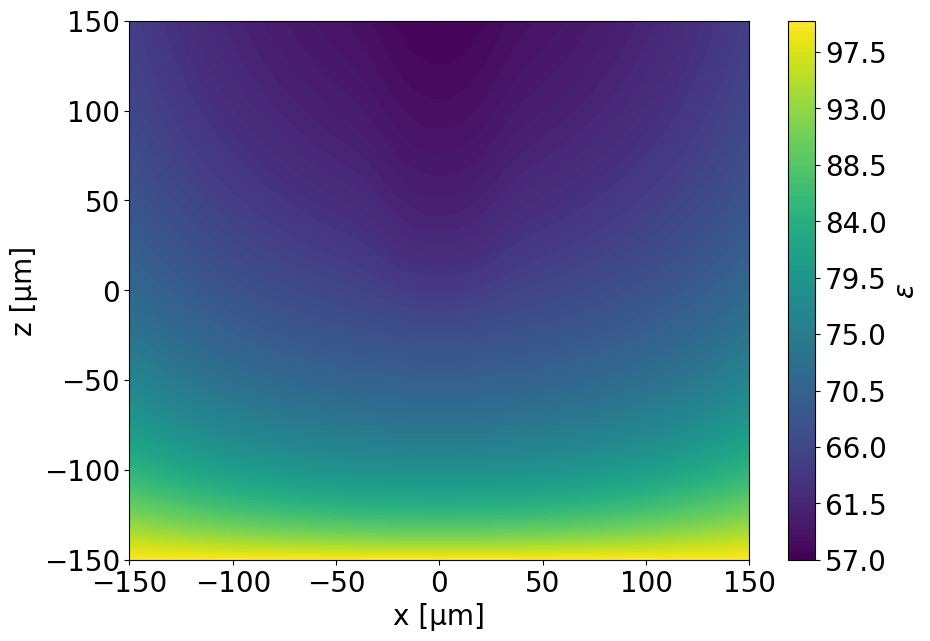

In [42]:
initial_setup.plot_parameter( np.sum(initial_setup.ε_grid,axis=2), r"$\epsilon$")

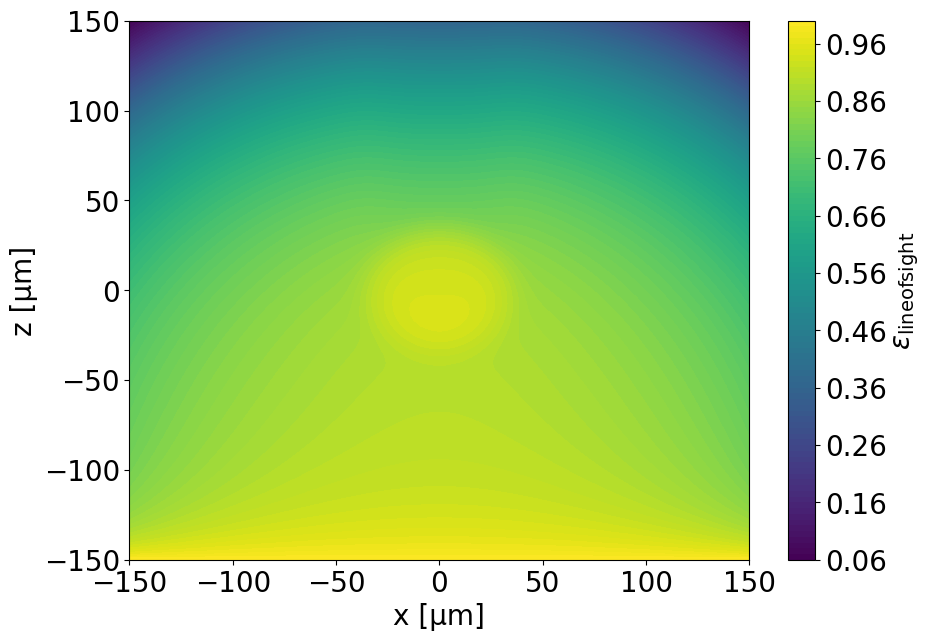

In [43]:
initial_setup.plot_parameter( np.sum(initial_setup.Iλ_grid,axis=2)/np.sum(initial_setup.Bλ_grid, axis=2), r"$\epsilon_{\rm line of sight}$")

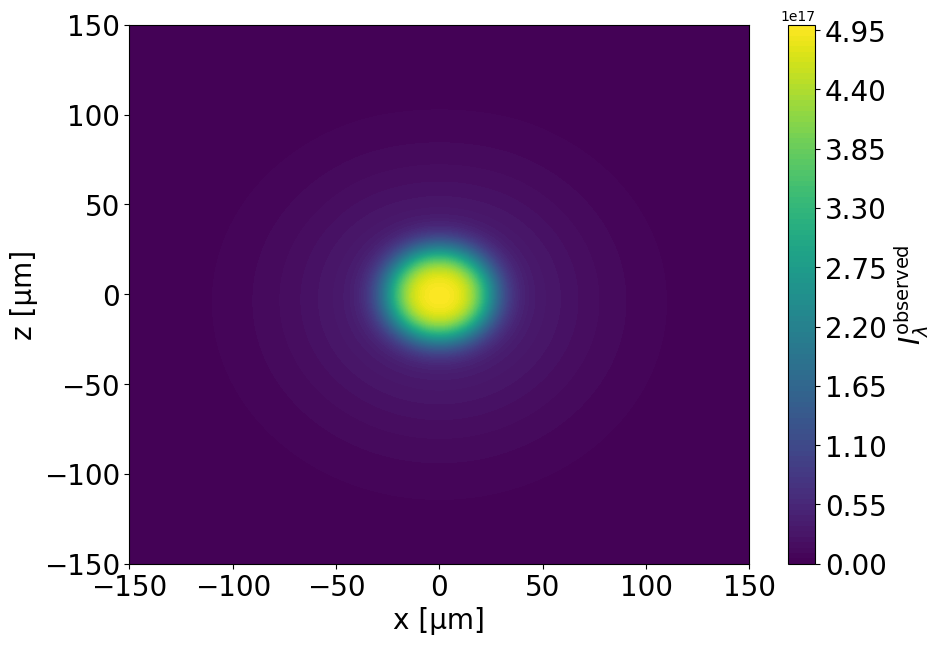

In [44]:
initial_setup.plot_parameter( np.sum(initial_setup.Iλ_grid,axis=2), r"$I_{\lambda}^{\rm observed}$")

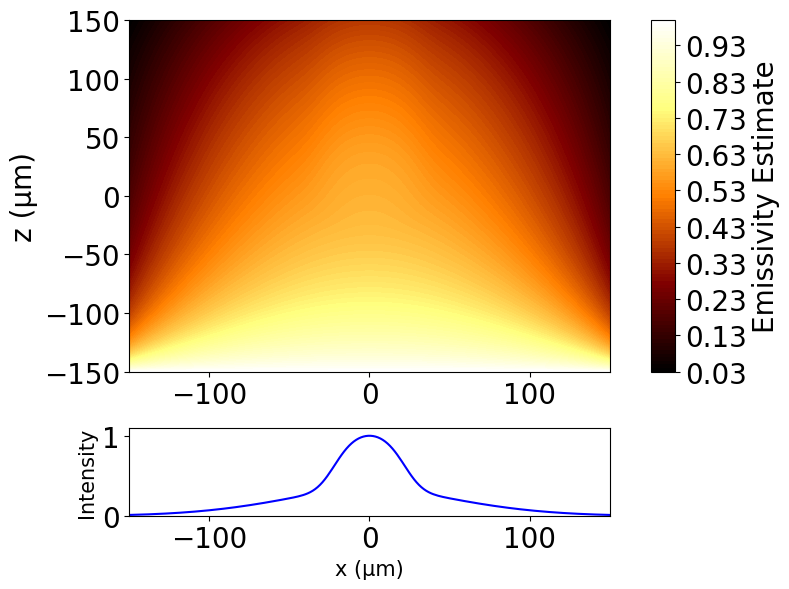

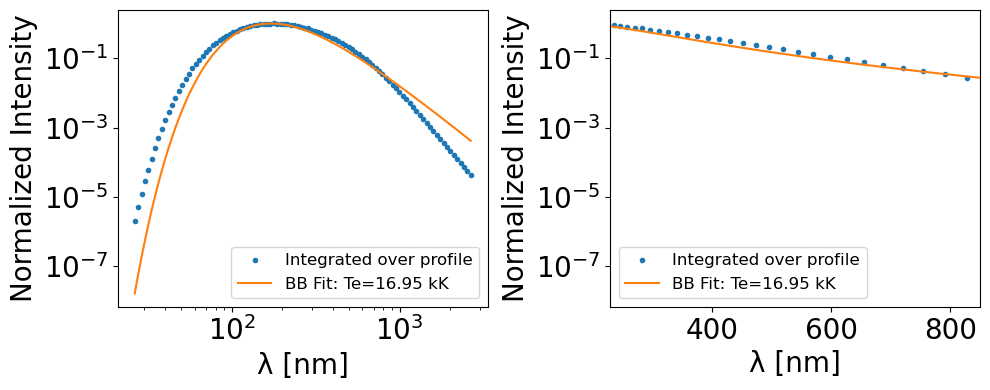

In [45]:
initial_setup.plot_emissivity_and_intensity(cmap='afmhot')
initial_setup.plot_spectral_Intensity()

# Run Hydrodynamic Simulation

In [46]:
%%time
χ0_factor = 3
ttm.experiment.χ0_func = lambda n_i, Te: 1 * eV_to_J
ttm.solve_hydro(tmax=10e-9, dt=1e-11, χ0_factor = χ0_factor)
# ttm.solve_hydro(tmax=5e-10, dt=1e-11, χ0_factor = χ0_factor)
# ttm.solve_hydro(tmax=1e-10, dt=1e-12, χ0_factor = χ0_factor)


KeyboardInterrupt



0 [0.70567316 0.01555616 0.15023281 1.        ]
1 [0.95665321 0.59803382 0.47730229 1.        ]
2 [0.86742764 0.8643766  0.86260246 1.        ]
3 [0.55431187 0.69009701 0.99551555 1.        ]
4 [0.2298057  0.29871797 0.75368315 1.        ]


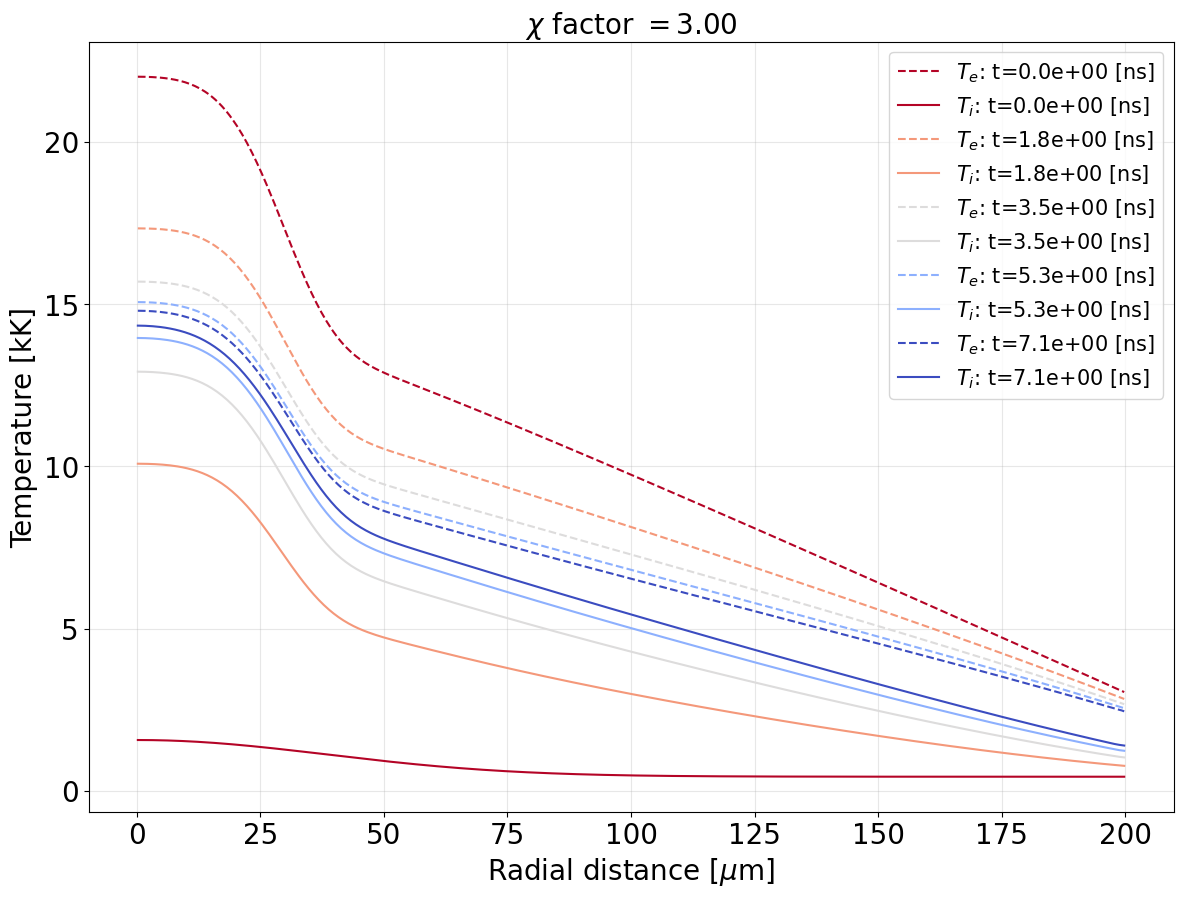

In [52]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):
    num_to_plot = 5
    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=num_to_plot,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    colors = plt.cm.coolwarm(np.linspace(0, 1,num_to_plot))[::-1]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '-', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            # ax.plot(grid.cell_centers*1e6, ttm.n_e_list[ti][:-1]/ttm.n_e_list[ti][0], '--', color=colors[plot_idx], label=f"$n_e$: t={t*1e9:.1e} [ns]")
            # ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '--' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
            # ax.plot(grid.cell_centers*1e6, ttm.Zbar_list[ti][:-1]/ttm.Zbar_list[ti][:-1][0], ':' , color=colors[plot_idx], label=r"$\langle Z \rangle$: t={0:.1e} [ns]".format(t*1e9))
            # ax.plot(grid.cell_centers*1e6, ttm.v_list[ti][:-1]/np.max(ttm.v_list[ti][:-1]), '-.' , color=colors[plot_idx], label=r"$v$: t={0:.1e} [ns]".format(t*1e9))
            # ax.plot(grid.cell_centers*1e6, 1.1*ttm.Ek_e_list[ti][:-1]/np.max(ttm.Ek_e_list[ti][:-1]), '-.' , color=colors[plot_idx], label=r"$E_K$: t={0:.1e} [ns]".format(t*1e9))
            # ax.plot(grid.cell_centers*1e6, ttm.n_e_list[ti][:-1]/ttm.n_e_list[ti][0]*ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$n_e$: t={t*1e9:.1e} [ns]")
            pass
        else:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
            # ax.plot(grid.cell_centers*1e6, ttm.Zbar_list[ti][:-1], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
            # ax.plot(grid.cell_centers*1e6, (ttm.n__list[ti][:-1])/(ttm.n_i_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Te_list[ti][1:])-(ttm.Te_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Ti_list[ti][1:])-(ttm.Ti_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            pass
        print(plot_idx, colors[plot_idx])
        plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    # ax.set_ylabel(r"T/T$_{\rm max}$",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(55,85)
#     ax.set_ylim(0,3)
#     ax.set_yscale('log')
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)

    
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
plot_temp_profiles(ttm, ax = ax[0], title=r'$\chi$ factor $ = {:0.2f}$'.format(χ0_factor), normalized=False, plot_times=None)#[12,13,14])


### Process Experimental Results at all times 

In [53]:
%%time
FWHM_list = []
FWHM_indices = list(range(len(ttm.t_saved_list) ))[::10]
FWHM_t_list = [] 
Te_fit_list = []
Intensity_list = []

for i in FWHM_indices:#[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 100, Nz=100)
    # FWHM_list.append(exp_i.FWHM)
    Te_fit_list.append(exp_i.Te_fit)
    FWHM_t_list.append(ttm.t_saved_list[i])
    # Intensity_list.append(exp_i.I_of_r_fit*np.max(exp_i.I_unnormalized_of_r))

CPU times: user 9.6 s, sys: 620 ms, total: 10.2 s
Wall time: 10.2 s


Text(0.5, 0.98, '$\\chi$ factor $ = 3.00$')

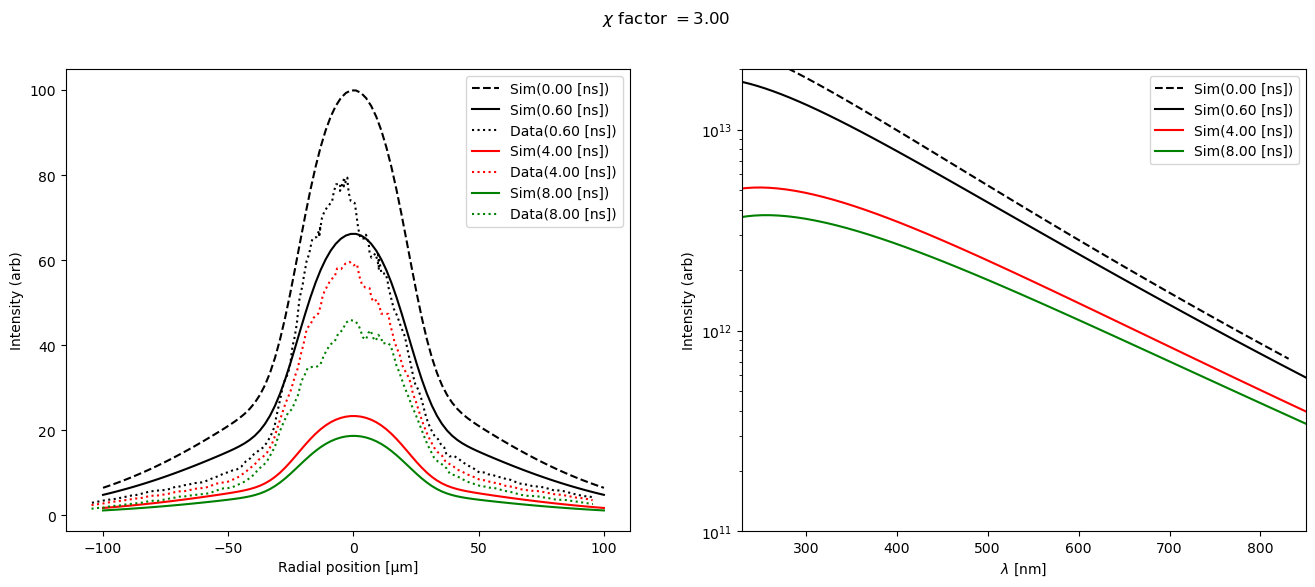

In [54]:
# profile_times = np.array([0.6, 4, 8, 12])*1e-9
profile_times = np.array([0,0.6, 4, 8])*1e-9
profile_time_indices = [np.argmin(np.abs(ttm.t_saved_list - t_profile)) for t_profile in profile_times]
profile_measurements  = [Measurements(Z, A, ttm.grid.r, ttm.n_e_list[ti], ttm.n_i_list[ti], ttm.Te_list[ti], ttm.Ti_list[ti], R_max = 100e-6, Nx = 100, Nz=100) for ti in profile_time_indices]

def plot_intensity(measurement, normalization = 1, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # ax.plot(measurement.x*1e6, measurement.I_of_r_fit, **kwargs)
    ax.plot(measurement.x*1e6, measurement.I_unnormalized_of_r*normalization, **kwargs)
    
    ax.set_ylabel("Intensity (arb)")
    ax.set_xlabel("Radial position [μm]")

def plot_intensity_over_λ(measurement, normalization = 1, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # ax.plot(measurement.x*1e6, measurement.I_of_r_fit, **kwargs)
    ax.plot(measurement.λs*1e9, measurement.Iλ_unnormalized, **kwargs)
    
    ax.set_ylabel("Intensity (arb)")
    ax.set_xlabel(r"$\lambda $ [nm]")

profile_files = ["data/" + f"Xe_5bar_profile_{time}ns.txt" for time in ["0.6","4","8","12"] ]    
profile_datasets = [] +  [read_csv(file, delim_whitespace=True, header=2) for file in profile_files]

fig, axs = plt.subplots(1,2, figsize=(16,6))
colors = ['k','k','r','g','b']
linestyles = ['--'] + ['-']*4
for i, (data, ti, t, measurement) in enumerate(zip(profile_datasets, profile_time_indices, profile_times, profile_measurements)):
    plot_intensity(measurement, ax=axs[0], color=colors[i], normalization =100/np.max(profile_measurements[0].I_unnormalized_of_r) , label=f"Sim({t*1e9:0.2f} [ns])",linestyle=linestyles[i])
    plot_intensity_over_λ(measurement, ax=axs[1], color=colors[i], normalization =100/np.max(profile_measurements[0].I_unnormalized_of_r) , label=f"Sim({t*1e9:0.2f} [ns])",linestyle=linestyles[i])
    
    if i>0:
        axs[0].plot(data['r[μm]']-5, data['I[arb]'], color=colors[i], linestyle=':', label=f"Data({t*1e9:0.2f} [ns])")
    
for ax in axs:
    ax.legend()

axs[1].set_xlim(230,850)
axs[1].set_yscale('log')
axs[1].set_ylim(1e11,2e13)

plt.suptitle( r'$\chi$ factor $ = {:0.2f}$'.format(χ0_factor))

# Comparison to Experiment
### Functions to Fit To

In [55]:
def Texp_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_fit_form(t, T0, ΔT, τei, τ_switch, t01,dTdt):
    return T0 + ΔT*np.exp(-2*t/τei) + (1-1/(1+np.exp( (t-t01)/τ_switch )))* dTdt

# def T_fit_form(t, T0, a, b, c):
#     return T0*1/(1+c**2*t**2) + a*np.exp(-2*t/b) 

def FWHM_adiabatic_fit_form(t, FWHM_0, vf):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) 

def FWHM_fit_form(t, FWHM_0, vf, a, b, c, d, t0):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( a*(t-t0))))* (b*t+ c)#+ d

# Te_vals   = curve_fit(Texp_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] ,maxfev=int(1e5))[0]#, -6.22682412e+03])[0]
# FWHM_vals = curve_fit(FWHM_fit_form, Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'] ,maxfev=int(1e4),p0=[47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2])[0]
# FWHM_sim_vals = curve_fit(FWHM_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e5),p0=(47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2))[0]
# Te_sim_vals = curve_fit(T_fit_form, np.array(FWHM_t_list)*1e9,np.array(Te_fit_list)/1e3 ,maxfev=int(1e5))[0]

# Te_sim_vals#, FWHM_sim_vals

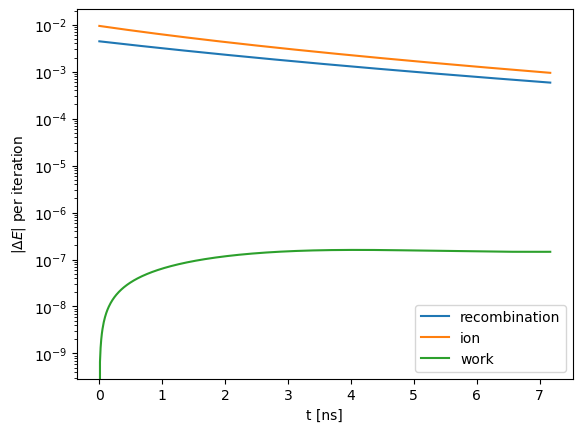

In [58]:
fig, ax = plt.subplots()

ax.plot(np.array(ttm.t_saved_list)*1e9, np.array(ttm.ΔEe_recombination_list), label="recombination")
ax.plot(np.array(ttm.t_saved_list)*1e9, -np.array(ttm.ΔEe_ion_equil_list), label="ion")
ax.plot(np.array(ttm.t_saved_list)*1e9, -np.array(ttm.ΔEe_work_list), label="work")
ax.set_yscale('log')
ax.set_xlabel('t [ns]')
ax.set_ylabel(r'$|\Delta E|$ per iteration')
ax.legend()

### Show Agreement with Experiment

In [1]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

dense_t_list = np.linspace(0,18,num=100)

# Plot Te
#Data and fit
# ax.plot(Xe_data['t[ns]'], Texp_fit_form(Xe_data['t[ns]'],*Te_vals), 'r--', label='Experiment Data')
ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'rx', label='Experiment Data')
# Simulation and Fit
ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'r.')
# ax.plot(dense_t_list, T_fit_form(dense_t_list,*Te_sim_vals),'r-')
# Extra
# ax.plot(np.array(FWHM_t_list)*1e9, T_fit_form(np.array(FWHM_t_list)*1e9,*Te_sim_vals),'r-')
# ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'.', color='r', )


ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',color='r', labelcolor='r')

ax2 = ax.twinx()
# Plot FWHM
#Data and fit
# ax2.plot(Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'], 'kx', label='Experiment Data')
# ax2.plot(Xe_FWHM_data['t[ns]'], FWHM_fit_form(Xe_FWHM_data['t[ns]'],*FWHM_vals),'k--')
# Simulation and Fit
# ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'.k')
# ax2.plot(dense_t_list, FWHM_fit_form(dense_t_list,*FWHM_sim_vals),'k-')

ax.set_title(r'$\chi$ factor = {0}'.format(χ0_factor), fontsize=20)


ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)
# ax.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_ylim(40,70)
ax.set_ylim(10,19)

legend_elements = [Line2D([0], [0], color='r', lw=2, label='Experimental Fit',linestyle='--'),
                   Line2D([0], [0], marker='x', color='r', label='Exerimental Data',
                          markerfacecolor='r', markersize=8,linewidth=0),
                   Line2D([0], [0], marker='.', color='r', label='Simulation Output',
                          markerfacecolor='r', markersize=8,linewidth=0),
                   Line2D([0], [0], color='r', lw=2, label='Simulation Fit', linestyle='-')]

ax.legend(handles=legend_elements, loc='upper left')

NameError: name 'plt' is not defined

### Intensity Contour Map

ValueError: zero-size array to reduction operation maximum which has no identity

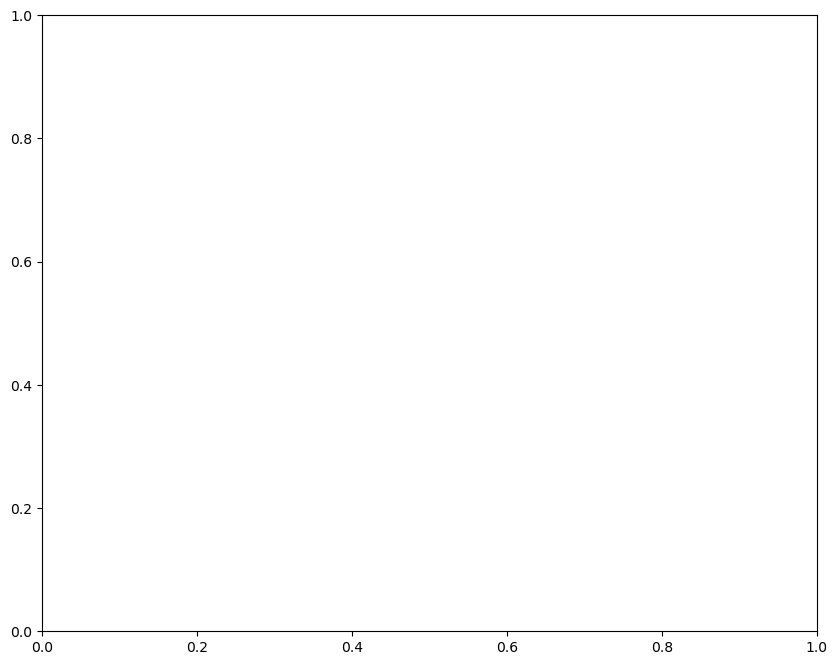

In [60]:
# Make a meshgrid for the contour plot
X, T = np.meshgrid(exp_i.x*1e6, np.array(FWHM_t_list)*1e9, indexing='ij')

# Create a custom colormap going from black at 0 to red at 0.5 to blue at 1
cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", ["black","red","yellow","white","lightskyblue"])

fig, ax = plt.subplots(figsize=(10,8))

# Create the contour plot
contour = ax.contourf(X, T, np.array(Intensity_list).T/np.max(Intensity_list), levels=100, cmap=cmap)

# Label the axes
ax.set_xlabel('x [μm]', fontsize=20)
ax.set_ylabel('t [ns]', fontsize=20)
ax.tick_params(labelsize=20)

ax.set_title(r'$\chi$ factor = {0}'.format(χ0_factor), fontsize=20)

# Reverse the y-axis direction to correct the upside-down tick labels
ax.invert_yaxis()

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label('Intensity', size=20)
cbar.ax.tick_params(labelsize=20)

plt.show()